# Short-Term Load Forecasting: A Dual-Model Approach

This project tackles the challenge of short-term energy load forecasting for commercial buildings using IBM's Tiny Time Mixer. We have added on some functionality using the LightGBM gradient boosting model

## Methodology

The notebook is structured to preprocess the data once and then generate two separate sets of predictions.

### 1. Data Preprocessing & Feature Engineering

Before modeling, the raw time-series data is enriched with several features to capture temporal patterns:
* **Time-Based Features:** `hour`, `dayofweek`, `month`, `day`, and `week` are extracted from the timestamp.
* **Lag Features:** The meter reading from 1 hour ago, 24 hours ago (yesterday), and 168 hours ago (last week) are included to capture recent trends and weekly seasonality.
* **Scaling:** Time-based features are standardized using `StandardScaler` to normalize their range.

The processed data is saved to `train_features.csv` and `test_features.csv`.

---

### 2. Model 1: LightGBM (Gradient Boosting)

This approach uses a traditional machine learning pipeline to train a model from scratch on the engineered features.

* **Model:** A LightGBM `gbdt` regressor is used for its efficiency and high performance.
* **Training:** The model is trained on 80% of the data, with performance monitored on a 20% validation set. Early stopping is used to prevent overfitting.
* **Prediction:** The best iteration of the trained model is used to predict the energy load on the preprocessed test data.
* **Output:** The predictions are saved to `submissionLightGBM.csv`.

### 3. Model 2: Tiny Time Mixer (TSFM) - Zero-Shot Forecasting

This approach leverages a pre-trained foundation model for time-series forecasting in a **zero-shot** setting, meaning the model is not trained on this specific dataset.

* **Model:** The `ibm-granite/granite-timeseries-ttm-r1` model is loaded directly from Hugging Face.
* **Data Preparation:** The raw test data is processed using the `TimeSeriesPreprocessor` from the `granite-tsfm` library, which handles scaling and formatting the data into the required context windows (512 timesteps).
* **Forecasting:** A `TimeSeriesForecastingPipeline` is used to generate predictions for each 24-hour window in the test set.
* **Output:** The predictions are saved to `submissionTSFM.csv`.

---

## How to Run

1.  Ensure the competition data from `/kaggle/input/short-term-load-forecasting/` is available.
2.  Run the cells in the notebook sequentially.
3.  The final outputs will be the two submission CSV files in the `/kaggle/working/` directory.

# Open the data page here to visualize the difference in the two models: https://hackathon-opal-three.vercel.app

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

input_path = "/kaggle/input/short-term-load-forecasting/"
train_path = os.path.join(input_path, "train.csv")
test_path = os.path.join(input_path, "test.csv")
sample_sub_path = os.path.join(input_path, "sample_submission.csv")


train = pd.read_csv(train_path, parse_dates=["timestamp"])
test = pd.read_csv(test_path, parse_dates=["timestamp"])
sub = pd.read_csv(sample_sub_path)


train = train.fillna(0)
test = test.fillna(0)


for df in [train, test]:
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["month"] = df["timestamp"].dt.month
    df["day"] = df["timestamp"].dt.day
    df["week"] = df["timestamp"].dt.isocalendar().week.astype(int)


def create_lags(df, group_col="building_id", target="meter_reading"):
    df = df.sort_values([group_col, "timestamp"])
    for lag in [1, 24, 168]:
        df[f"lag_{lag}"] = df.groupby(group_col)[target].shift(lag)
    return df

train = create_lags(train)

train = train.dropna()

scaler = StandardScaler()
scale_cols = ["hour", "dayofweek", "month", "day", "week"]

train[scale_cols] = scaler.fit_transform(train[scale_cols])
test[scale_cols] = scaler.transform(test[scale_cols])


train = train.drop(columns=["timestamp"])
test = test.drop(columns=["timestamp"])

train.to_csv("/kaggle/working/train_features.csv", index=False)
test.to_csv("/kaggle/working/test_features.csv", index=False)

print(" Preprocessing complete!")
print("Saved: train_features.csv & test_features.csv in /kaggle/working/")

 Preprocessing complete!
Saved: train_features.csv & test_features.csv in /kaggle/working/


Train shape: (2567688, 12)
Test shape: (676800, 10)
Feature matrix shape: (2567688, 5)
Target vector shape: (2567688,)
Training set shape: (2054150, 5) (2054150,)
Validation set shape: (513538, 5) (513538,)
LightGBM train dataset created.
LightGBM validation dataset created.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 2054150, number of used features: 5
[LightGBM] [Info] Start training from score 0.825978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[924]	train's rmse: 0.90285	val's rmse: 0.899941
Training complete!
First 10 predictions: [0.57649246 0.53471192 0.50824215 0.48960065 0.51604726 0.70138933
 1.06463779 1.39128832 1.03275892 0.98703882]
Submission file sav

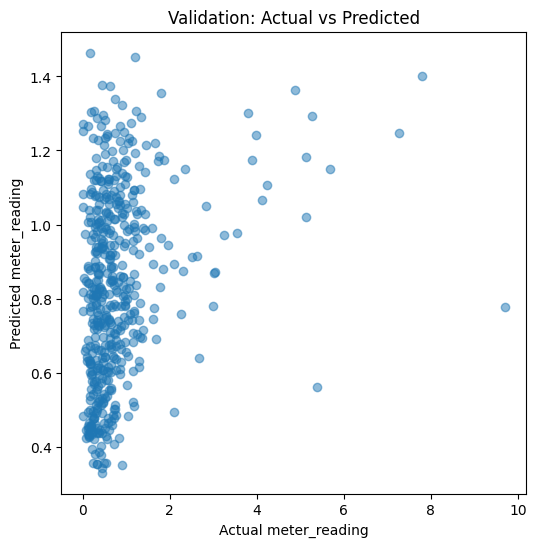

In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Paths
train_path = "/kaggle/working/train_features.csv"
test_path = "/kaggle/working/test_features.csv"

# Load data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Common features
common_features = ['hour', 'dayofweek', 'month', 'day', 'week']

# Features and target
X = train_df[common_features]
y = train_df['meter_reading']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

# LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

print("LightGBM train dataset created.")
print("LightGBM validation dataset created.")

# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42
}

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50)]
)
print("Training complete!")

# Predictions on test set
X_test = test_df[common_features]
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

print("First 10 predictions:", test_preds[:10])

# Submission
submission = pd.DataFrame({
    "row_id": test_df['row_id'],
    "meter_reading": test_preds
})
submission.to_csv("submissionLightGBM.csv", index=False)
print("Submission file saved!")
print(submission.head())

# Validation predictions
val_preds = model.predict(X_val, num_iteration=model.best_iteration)

# RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print("Validation RMSE:", rmse)

# Plot actual vs predicted (first 500 points for clarity)
plt.figure(figsize=(6, 6))
plt.scatter(y_val[:500], val_preds[:500], alpha=0.5)
plt.xlabel("Actual meter_reading")
plt.ylabel("Predicted meter_reading")
plt.title("Validation: Actual vs Predicted")
plt.show()


In [3]:
!pip install --no-deps granite-tsfm[notebooks] -q

!pip install "transformers==4.41.2" "accelerate==0.29.3" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installe

2025-09-17 18:21:41.228820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758133301.504676      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758133301.584220      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Successfully loaded test.csv.

Visualizing random windows from the data...


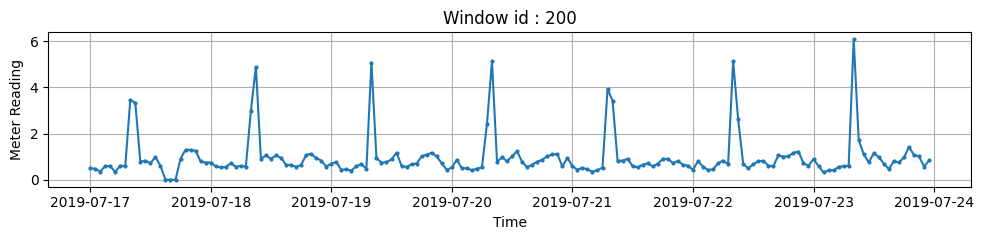

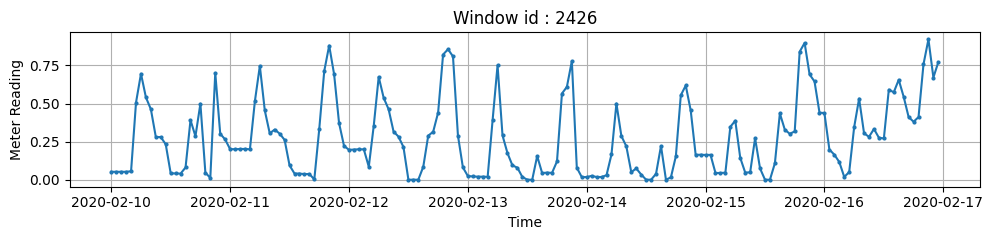

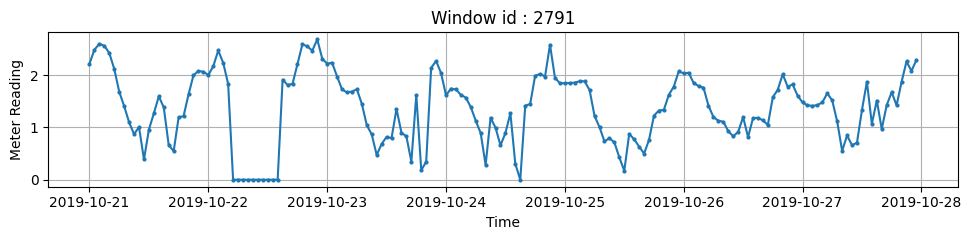

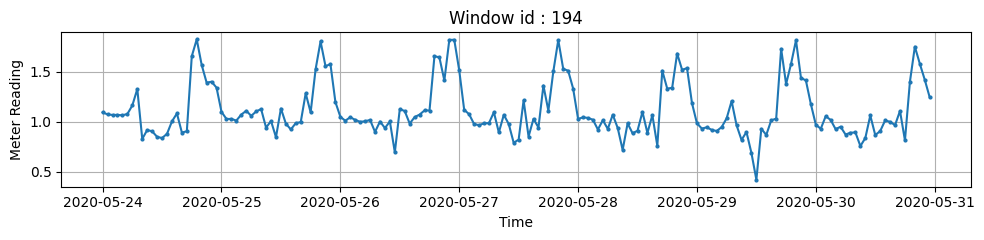

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

Model setup complete.

Setting up the data preprocessor...
Preprocessor training complete.

Creating the forecasting pipeline...
Pipeline created on device: cpu

Running forecasting on all windows... (This may take some time)
  Processing window 100/3525
  Processing window 200/3525
  Processing window 300/3525
  Processing window 400/3525
  Processing window 500/3525
  Processing window 600/3525
  Processing window 700/3525
  Processing window 800/3525
  Processing window 900/3525
  Processing window 1000/3525
  Processing window 1100/3525
  Processing window 1200/3525
  Processing window 1300/3525
  Processing window 1400/3525
  Processing window 1500/3525
  Processing window 1600/3525
  Processing window 1700/3525
  Processing window 1800/3525
  Processing window 1900/3525
  Processing window 2000/3525
  Processing window 2100/3525
  Processing window 2200/3525
  Processing window 2300/3525
  Processing window 2400/3525
  Processing window 2500/3525
  Processing window 2600/3525
  P

In [4]:
# STEP 1: Fix the environment by installing the correct library versions.
# After this command finishes, the kernel will restart automatically.
# RUN THIS ENTIRE CELL AGAIN AFTER THE RESTART.
!pip install "transformers==4.42.2" "granite-tsfm[notebooks]==0.3.1"

# --- Main Notebook Code Starts Here ---
# Ensure you have uploaded 'test.csv' before running this cell for the second time.

# ## Imports
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
    TimeSeriesPreprocessor,
)

# ## Specify time and output variables
timestamp_column = "timestamp"
target_columns = ["meter_reading"]
context_length = 512
forecast_length = 96  # Note: The model is configured for a forecast of 96 steps.

# ## Read in the data
# IMPORTANT: This step requires 'test.csv' to be uploaded to your notebook environment.
try:
    DATA_FILE_PATH='/kaggle/input/short-term-load-forecasting/test.csv'
    input_df = pd.read_csv(
        DATA_FILE_PATH,
        parse_dates=[timestamp_column],
    )
    print("Successfully loaded test.csv.")
except FileNotFoundError:
    print("---")
    print("!!! ERROR: 'test.csv' not found. Please upload the file and run this cell again. !!!")
    print("---")
    # We will stop the script here if the file is not found.
    raise

# ## Visualizing the data
print("\nVisualizing random windows from the data...")
window_ids = input_df["window_id"].unique().tolist()
random_windows = random.sample(window_ids, min(4, len(window_ids))) # Ensure we don't sample more than available windows

for w in random_windows:
    window_df = input_df[input_df["window_id"] == w]
    plt.figure(figsize=(10, 2.5))
    plt.plot(window_df["timestamp"], window_df["meter_reading"], marker="o", ms=2)
    plt.xlabel("Time")
    plt.ylabel("Meter Reading")
    plt.title(f"Window id : {w}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ## Set up zero shot model
print("\nDownloading and setting up the pre-trained TTM model...")
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r1",  # 512-96 TTM model
    revision='main',
    num_input_channels=len(target_columns),
)
print("Model setup complete.")

# ## Create the Time Series Processor (tsp)
print("\nSetting up the data preprocessor...")
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [],
}
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    forecast_length=forecast_length,
    scaling=True,
    scaler_type="standard",
    freq='h'
)
tsp.train(input_df)
print("Preprocessor training complete.")

# ## Create a forecasting pipeline
print("\nCreating the forecasting pipeline...")
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    explode_forecasts=True,
    feature_extractor=tsp,
    device=device,
)
print(f"Pipeline created on device: {device}")

# ## Running on all windows to generate submission file
print("\nRunning forecasting on all windows... (This may take some time)")
window_ids = input_df["window_id"].unique().tolist()
submission = pd.DataFrame()

for i, wi in enumerate(window_ids):
    if (i + 1) % 100 == 0:
        print(f"  Processing window {i+1}/{len(window_ids)}")
    window_df = input_df[input_df["window_id"] == wi]
    current_input_df = window_df[window_df["role"].isin(['input'])]
    current_output_df = window_df[window_df["role"].isin(['target'])]
    zeroshot_forecast = pipeline(current_input_df)
    
    # NOTE: The forecast_length is 96, but the submission requires 24 predictions.
    # The original notebook correctly slices the first 24 forecasts.
    zeroshot_forecast = zeroshot_forecast.iloc[:24]
    
    submission_temp = pd.DataFrame({
        "row_id": current_output_df['row_id'].reset_index(drop=True),
        "meter_reading" : zeroshot_forecast['meter_reading'].reset_index(drop=True)
        })
    submission = pd.concat([submission, submission_temp], axis=0).reset_index(drop=True)

print("Forecasting complete.")

# ## Save and display submission file
submission.to_csv("submissionTSFM.csv", index=False)
print("\nsubmission.csv has been generated successfully!")
print("\nFirst 5 rows of the submission file:")
print(submission.head())